<a href="https://colab.research.google.com/github/UvaRoobini/CSE/blob/main/knee_disease_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

In [3]:
np.random.seed(12049)

In [4]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()


def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [5]:
base_dir = "/content/kneedataset"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

In [6]:
model_name = "Xception"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('H:\Xception', f'Xception_model.hdf5')

In [9]:
!git clone https://github.com/UvaRoobini/kneedataset.git


Cloning into 'kneedataset'...
remote: Enumerating objects: 5504, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 5504 (delta 0), reused 9 (delta 0), pack-reused 5475
Receiving objects: 100% (5504/5504), 112.67 MiB | 35.72 MiB/s, done.


In [7]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

In [10]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1172 images belonging to 5 classes.
Found 214 images belonging to 5 classes.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [12]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 275, 1: 275, 2: 275, 3: 275, 4: 72}
{0: 0.8523636363636363, 1: 0.8523636363636363, 2: 0.8523636363636363, 3: 0.8523636363636363, 4: 3.2555555555555555}


In [14]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [15]:
model = tf.keras.applications.xception.Xception(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

83683744/83683744 [==============================] - 0s 0us/step


In [16]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 20817197 (79.41 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [17]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100
37/37 [==============================] - 65s 787ms/step - loss: 1.6104 - accuracy: 0.2432 - val_loss: 1.5643 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 25s 657ms/step - loss: 1.5847 - accuracy: 0.2432 - val_loss: 27.4520 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 25s 665ms/step - loss: 1.3242 - accuracy: 0.3311 - val_loss: 174.2618 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 25s 663ms/step - loss: 1.0621 - accuracy: 0.4744 - val_loss: 69.6249 - val_accuracy: 0.2570 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 25s 673ms/step - loss: 0.9476 - accuracy: 0.5290 - val_loss: 85.9878 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 25s 672ms/step - loss: 0.9132 - accuracy: 0.5427 - val_loss: 4.7887 - val_accuracy: 0.3318 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 

In [18]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model Xception fine tuning executed in 9.38 minutes


In [19]:
model_ft.save(save_model_ft)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


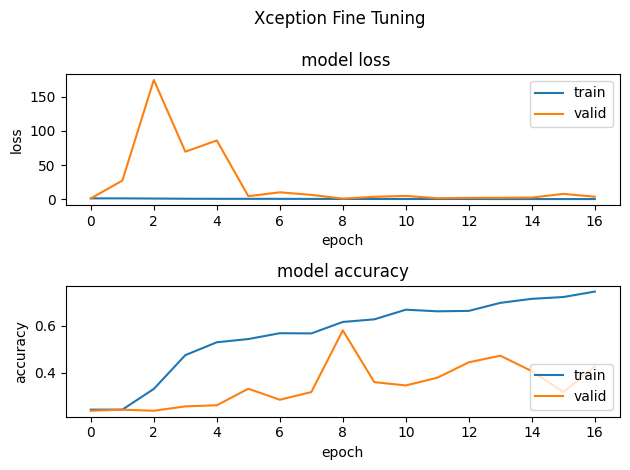

In [20]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [21]:
get_evaluate(valid_generator, "Valid", model_ft)

7/7 [==============================] - 1s 133ms/step - loss: 1.1896 - accuracy: 0.5794
Valid loss: 1.19
Valid accuracy: 0.58


In [22]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

7/7 [==============================] - 2s 144ms/step
Accuracy Score - Xception: 0.58
Balanced Accuracy Score - Xception: 0.58


              precision    recall  f1-score   support

           0       0.51      0.80      0.63        51
           1       0.55      0.22      0.31        50
           2       0.53      0.62      0.57        50
           3       0.72      0.66      0.69        50
           4       0.80      0.62      0.70        13

    accuracy                           0.58       214
   macro avg       0.62      0.58      0.58       214
weighted avg       0.59      0.58      0.56       214



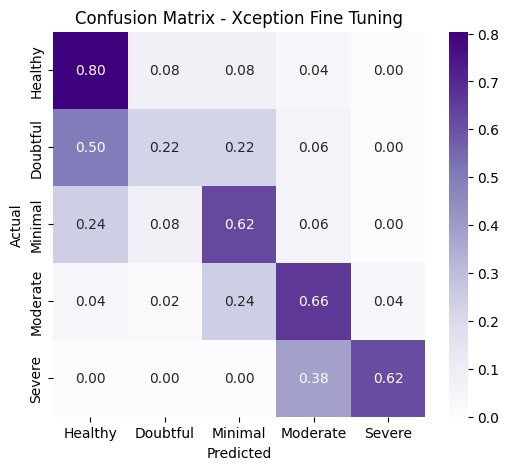

In [23]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)